In [26]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import joblib

## 1. DATA EXPLORATION & PREPROCESSING

In [27]:
# Load dataset
df = pd.read_csv("labeled_data.csv")

# Drop unnecessary index column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

In [28]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [29]:
# Display dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB
None


In [30]:
# Class mapping (dataset-specific)
label_map = {0: "hate_speech", 1: "offensive", 2: "neither"}
df["class_label"] = df["class"].map(label_map)

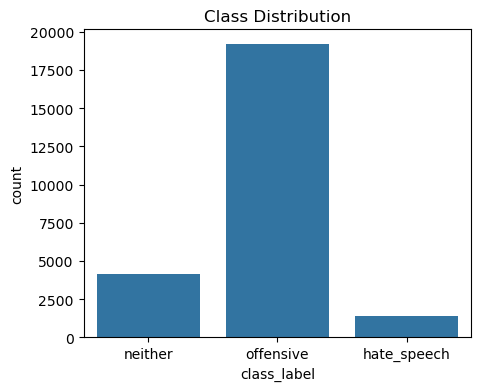

In [31]:
# Check class distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df, x="class_label")
plt.title("Class Distribution")
plt.show()

In [32]:
# Check tweet lengths
df["tweet_len"] = df["tweet"].astype(str).apply(len)

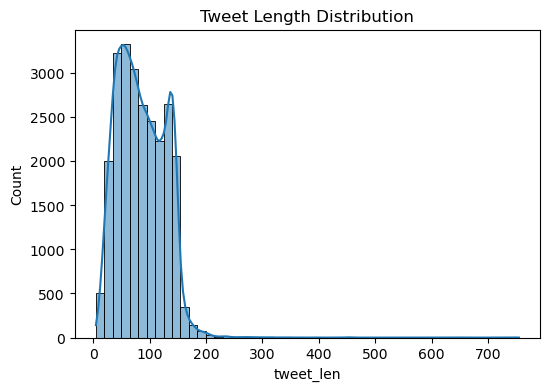

In [33]:
plt.figure(figsize=(6,4))
sns.histplot(df["tweet_len"], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.show()

In [34]:
#cleaning function
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " URL ", text)
    text = re.sub(r"@\w+", " USER ", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_tweet"] = df["tweet"].astype(str).apply(clean_tweet)

In [35]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,class_label,tweet_len,clean_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither,140,rt USER as a woman you shouldn t complain abou...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive,85,rt USER boy dats cold tyga dwn bad for cuffin ...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive,120,rt USER dawg rt USER you ever fuck a bitch and...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive,62,rt USER USER she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive,137,rt USER the shit you hear about me might be tr...


## 2. FEATURE ENGINEERING (TF-IDF + SVD + NUMERIC FEATURES)

In [36]:
# TEXT FEATURE EXTRACTION - TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(df["clean_tweet"])

In [37]:
# PCA-like Dimensionality Reduction — Using TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

In [38]:
# NUMERIC FEATURES
numeric_features = df[["count", "hate_speech", "offensive_language", "neither", "tweet_len"]].copy()

# Outlier Handling — IQR capping
for col in numeric_features.columns:
    Q1 = numeric_features[col].quantile(0.25)
    Q3 = numeric_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    numeric_features[col] = numeric_features[col].clip(lower, upper)

In [39]:
# Scaling numeric features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(numeric_features)

In [40]:
# COMBINE ALL FEATURES
X_final = np.hstack([X_svd, X_num_scaled])
y = df["class"]

In [41]:
X_final

array([[ 0.14952409, -0.05727731, -0.08640252, ..., -1.76804492,
         0.        ,  1.35368507],
       [ 0.12956642, -0.0425775 , -0.07578596, ...,  0.55348357,
         0.        , -0.00639747],
       [ 0.32063697,  0.01869936, -0.14651229, ...,  0.55348357,
         0.        ,  0.8591096 ],
       ...,
       [ 0.02715462,  0.01165101, -0.02201294, ...,  0.55348357,
         0.        , -0.45151539],
       [ 0.03704205, -0.01925239, -0.06858133, ...,  1.94640066,
         0.        , -1.19337859],
       [ 0.04199384, -0.00782508, -0.04903537, ..., -1.76804492,
         0.        ,  1.03221101]], shape=(24783, 105))

In [42]:
y

0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64

## 3. MODEL SELECTION (MULTIPLE ALGORITHMS + BEST MODEL PICKER)

In [43]:
# TRAIN–TEST SPLIT 
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
# Define multiple machine learning models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVM": LinearSVC(),
    "SVC RBF": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Bernoulli NB": BernoulliNB()
}

In [45]:
# Training each model and storing results
results = {}

for name, model in models.items():
    print(f"\nTraining Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    results[name] = {
        "model": model,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_macro": f1
    }

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


Training Model: Logistic Regression
Accuracy: 0.9752
Precision: 0.9455
Recall: 0.8681
F1-Score: 0.8945

Training Model: Linear SVM
Accuracy: 0.9740
Precision: 0.9474
Recall: 0.8588
F1-Score: 0.8870

Training Model: SVC RBF
Accuracy: 0.9726
Precision: 0.9497
Recall: 0.8484
F1-Score: 0.8781

Training Model: Random Forest
Accuracy: 0.9774
Precision: 0.9452
Recall: 0.8840
F1-Score: 0.9070

Training Model: Gradient Boosting
Accuracy: 0.9748
Precision: 0.9232
Recall: 0.8836
F1-Score: 0.8998

Training Model: KNN (k=5)
Accuracy: 0.9582
Precision: 0.8772
Recall: 0.7832
F1-Score: 0.8037

Training Model: Bernoulli NB
Accuracy: 0.8350
Precision: 0.6284
Recall: 0.6418
F1-Score: 0.6331


In [46]:
# SELECT BEST MODEL USING ACCURACY
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = results[best_model_name]["model"]

print("\n" + "="*70)
print(f"BEST MODEL SELECTED BASED ON ACCURACY: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print("="*70)


BEST MODEL SELECTED BASED ON ACCURACY: Random Forest
Accuracy: 0.9774


## 4.Hyperparameter Tuning

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
#since best model selection was Random Forest so tuning for Ramdom Forest only
if best_model_name == "Random Forest":

    rf_base = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,           # parallelize tree building
        class_weight="balanced"  # helps minority class (hate_speech)
    )

    # Small but effective search space (high-impact parameters only)
    param_dist = {
        "n_estimators": [150, 200, 300],          # number of trees
        "max_depth": [None, 15, 25],              # control overfitting
        "min_samples_split": [2, 5, 10],          # control complexity
        "min_samples_leaf": [1, 2, 4],            # control complexity
        "max_features": ["sqrt", "log2"],         # feature sampling
        "bootstrap": [True]                       # keep fixed to reduce search size
    }
    # Random search = tries only n_iter combinations instead of all combinations
    random_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_dist,
        n_iter=20,              
        scoring="f1_macro",    
        cv=3,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    print("\n" + "="*70)
    print("HYPERPARAMETER TUNING RESULTS (Random Forest)")
    print("Best Parameters:", random_search.best_params_)
    print(f"Best CV F1 (macro): {random_search.best_score_:.4f}")
    print("="*70)

else:
    print("Tuning code currently set up for Random Forest only.")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

HYPERPARAMETER TUNING RESULTS (Random Forest)
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}
Best CV F1 (macro): 0.8947


## 5. MODEL EVALUATION


Classification Report:
              precision    recall  f1-score   support

 hate_speech       0.92      0.67      0.77       286
   offensive       1.00      1.00      1.00      3838
     neither       0.91      0.97      0.94       833

    accuracy                           0.98      4957
   macro avg       0.94      0.88      0.90      4957
weighted avg       0.98      0.98      0.97      4957



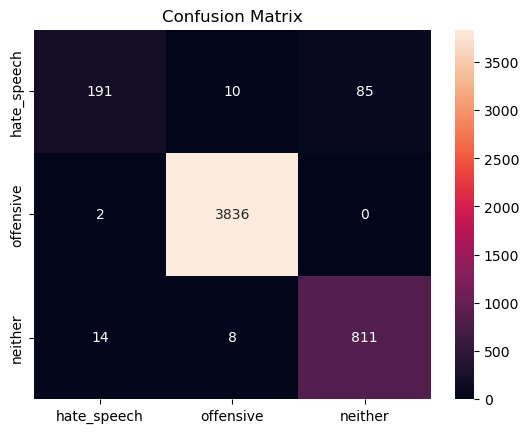

In [49]:
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_map.values())))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix")
plt.show()

## 6. SAVING THE MODEL FOR DEPLOYMENT

In [50]:
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(svd, "svd_reducer.joblib")
joblib.dump(scaler, "numeric_scaler.joblib")
joblib.dump(best_model, "hate_speech_best_model.joblib")

['hate_speech_best_model.joblib']

## 7. DEPLOYMENT — PREDICT FUNCTION FOR NEW TEXT

In [51]:
def predict_new_tweet(text):
    text_clean = clean_tweet(text)
    
    vec = joblib.load("tfidf_vectorizer.joblib")
    svd = joblib.load("svd_reducer.joblib")
    scaler = joblib.load("numeric_scaler.joblib")
    model = joblib.load("hate_speech_best_model.joblib")

    # TF-IDF → SVD
    x_tfidf = vec.transform([text_clean])
    x_svd = svd.transform(x_tfidf)

    # approximate numeric features
    tweet_len = len(text_clean)
    dummy_numeric = np.array([[0,0,0,0,tweet_len]])   # minimal numeric info
    dummy_numeric = scaler.transform(dummy_numeric)

    x_final = np.hstack([x_svd, dummy_numeric])

    pred_class = model.predict(x_final)[0]
    return label_map[pred_class]

In [52]:
# Example usage
print(predict_new_tweet("I hate these people!"))
print(predict_new_tweet("Have a nice day everyone!"))

hate_speech
neither
